In [1]:
%load_ext autoreload
%autoreload 2
import os
import imageio
import ast
import re
import skimage
import json
import numpy as np
from itertools import islice
from shutil import rmtree
from PIL import Image
from tqdm import tqdm_notebook

from IPython.display import clear_output
from IPython.core.debugger import set_trace
from IPython.display import clear_output

import torch
from torch import nn 
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchvision import models
import torchvision
from torch import autograd

from dataset import FashionEdgesDataset
from utils import vis_batch, tensor2numpy, save_batch, save_dict, collate_fn

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
class Basic2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size):
        super(Basic2DBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=1, padding=((kernel_size-1)//2)),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)


class Pool2DBlock(nn.Module):
    def __init__(self, pool_size):
        super(Pool2DBlock, self).__init__()
        self.pool_size = pool_size

    def forward(self, x):
        return F.max_pool2d(x, kernel_size=self.pool_size, stride=self.pool_size)


class Res2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(Res2DBlock, self).__init__()
        self.res_branch = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True),
            nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_planes)
        )

        if in_planes == out_planes:
            self.skip_con = nn.Sequential()
        else:
            self.skip_con = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        res = self.res_branch(x)
        skip = self.skip_con(x)
        return F.relu(res + skip, True)


class Upsample2DBlock(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride):
        super(Upsample2DBlock, self).__init__()
        assert(kernel_size == 2)
        assert(stride == 2)
        self.block = nn.Sequential(
            nn.ConvTranspose2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=0, output_padding=0),
            nn.BatchNorm2d(out_planes),
            nn.ReLU(True)
        )

    def forward(self, x):
        return self.block(x)
      
class Generator(nn.Module):
    def __init__(self, input_features_dim=64, output_features_dim=3, noise_dim=512, size=4):
        super().__init__()
        
        self.size = size
        self.input_features_dim = input_features_dim
        self.output_features_dim = output_features_dim
        
        self.preprocess = nn.Sequential(
            nn.Linear(noise_dim, size * size * input_features_dim),
            nn.ReLU(True)
        )

        self.front_layer1 = Basic2DBlock(input_features_dim, 32, 7)
        self.front_layer2 = Res2DBlock(32, 64)
        self.front_layer3 = Res2DBlock(64, 128)

        self.mid_res = Res2DBlock(128, 128)

        self.decoder_res5 = Res2DBlock(128, 128)
        self.decoder_upsample5 = Upsample2DBlock(128, 128, 2, 2)
        self.decoder_res4 = Res2DBlock(128, 128)
        self.decoder_upsample4 = Upsample2DBlock(128, 128, 2, 2)
        self.decoder_res3 = Res2DBlock(128, 128)
        self.decoder_upsample3 = Upsample2DBlock(128, 128, 2, 2)
        self.decoder_res2 = Res2DBlock(128, 128)
        self.decoder_upsample2 = Upsample2DBlock(128, 64, 2, 2)
        self.decoder_res1 = Res2DBlock(64, 64)
        self.decoder_upsample1 = Upsample2DBlock(64, 32, 2, 2)

        self.back_layer1 = Res2DBlock(32, 32)
        self.back_layer2 = Basic2DBlock(32, 16, 1)
        self.back_layer3 = Basic2DBlock(16, 16, 1)

        self.output_layer = nn.Conv2d(16, output_features_dim, kernel_size=1, stride=1, padding=0)


    def forward(self, x, params=None):
        
        batch_size = x.shape[0]
        
        x = self.preprocess(x)
        x = x.view(batch_size, self.input_features_dim, self.size, self.size)
        
        x = self.front_layer1(x)
        x = self.front_layer2(x)
        x = self.front_layer3(x)

        x = self.mid_res(x)

        x = self.decoder_res5(x)
        x = self.decoder_upsample5(x)
        x = self.decoder_res4(x)
        x = self.decoder_upsample4(x)
        x = self.decoder_res3(x)
        x = self.decoder_upsample3(x)
        x = self.decoder_res2(x)
        x = self.decoder_upsample2(x)
        x = self.decoder_res1(x)
        x = self.decoder_upsample1(x)

        x = self.back_layer1(x)
        x = self.back_layer2(x)
        x = self.back_layer3(x)

        x = self.output_layer(x)

        return x.sigmoid() #[128,128]
      
# class Discriminator(nn.Module):
    
#     def __init__(self):
#         super().__init__()
        
#         self.model = models.resnet50(pretrained=False)
#         self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)
#     def forward(self,x):
#         return self.model(x)

class Discriminator(nn.Module):
    
    def __init__(self, DIM = 128):
        super().__init__()

        self.features = nn.Sequential(nn.Conv2d(3, DIM, 3,padding=1),
                                      nn.LeakyReLU(),
                                      nn.Conv2d(DIM, 2 * DIM, 3, 2, padding=1),
                                      nn.LeakyReLU(),
                                      nn.Conv2d(2 * DIM, 4 * DIM, 3, 2, padding=1),
                                      nn.LeakyReLU(),
                                      nn.Conv2d(4 * DIM, 4 * DIM, 3, 2, padding=1),
                                      nn.LeakyReLU(),
                                      nn.Conv2d(4 * DIM, 4 * DIM, 3, 2, padding=1),
                                      nn.LeakyReLU(),
                                      nn.Conv2d(4 * DIM, 3 * DIM, 3, 2, padding=1),
                                      nn.LeakyReLU(),
                                      nn.Conv2d(3 * DIM, 2 * DIM, 3, 1, padding=1),
                                      nn.LeakyReLU(),
                                      nn.Conv2d(2 * DIM, 2*DIM, 3, 1),
                                      nn.LeakyReLU())
      
        self.linear = nn.Linear(in_features=1024, out_features=1, bias=True)
      
    def forward(self,x):
        batch_size = x.shape[0]
        x = self.features(x) 
        x = x.view(batch_size, -1)
        x = self.linear(x)
        return x
      
class PerceptualLoss(torch.nn.Module):

    def __init__(self, vgg):
        super(PerceptualLoss, self).__init__()
        self.vgg = vgg
        self.vgg_layers = vgg.features
        self.layer_name_mapping = ['3','8', '15','22','29']
   
                
    def forward(self, x1, x2):
        loss = 0
        x = torch.cat((x1,x2),0)
        for name, module in self.vgg_layers._modules.items():
            x1 = module(x1)
            x2 = module(x2)
            if name in self.layer_name_mapping:
                BS,C,H,W = x1.shape
                loss += ((x1 - x2).pow(2) / (C*H*W)).sum()
        return loss
       

In [3]:
def calc_gradient_penalty(netD, real_data, fake_data):
    batch_size = real_data.shape[0]
    # print "real_data: ", real_data.size(), fake_data.size()
    alpha = torch.rand(batch_size, 1)
    alpha = alpha.expand(batch_size, int(real_data.nelement()/batch_size)).contiguous().view(batch_size, 3, 128, 128)
    alpha = alpha.cuda()

    interpolates = alpha * real_data + ((1 - alpha) * fake_data)

    interpolates = interpolates.cuda()
    interpolates = autograd.Variable(interpolates, requires_grad=True)

    disc_interpolates = netD(interpolates)

    gradients = autograd.grad(outputs=disc_interpolates, inputs=interpolates,
                              grad_outputs=torch.ones(disc_interpolates.size()).cuda(),
                              create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * LAMBDA
    return gradient_penalty

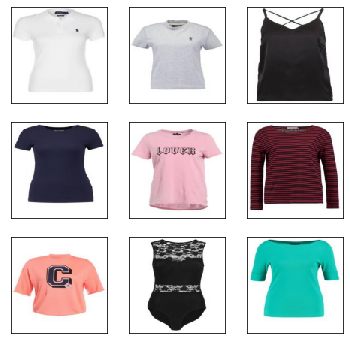

In [26]:
BATCH_SIZE = 10
images_fold = '../cp-vton/'
train_dataset = FashionEdgesDataset(images_fold, attr_file=None)
train_loader = DataLoader(train_dataset,
                          batch_size = BATCH_SIZE,
                          collate_fn=collate_fn,
                          shuffle=True)

for batch in train_loader:
    break

vis_batch(batch[1], 36)
N = len(train_loader)

In [5]:
continue_training = True
use_perceptual_loss = True
exp_path = '../checkpoints_wgan/'
if not os.path.isdir(exp_path):
    os.mkdir(exp_path)
    
LAMBDA = 10 # Gradient penalty lambda hyperparameter
DISCR_FREQ = 1 
GEN_FREQ = 5
LR_G = 1e-4
LR_D = 1e-4
VIS_FREQ = 1
EPOCHS = 10000
SAVE_FREQ = 2
PERC_LOSS_WEIGHT = 1.
NOISE_DIM = 512
SIZE = 4

one = torch.FloatTensor([1])
mone = one * -1
one = one.cuda()
mone = mone.cuda()

netG = Generator().cuda()
optimizerG = torch.optim.Adam(netG.parameters(), LR_G, betas=(0.5,0.9))
netD = Discriminator().cuda()
optimizerD = torch.optim.Adam(netD.parameters(), LR_D, betas=(0.5,0.9))

mn = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(NOISE_DIM), torch.eye(NOISE_DIM))

if use_perceptual_loss:
    vgg = torchvision.models.vgg16(pretrained=True).cuda()
    perceptual_loss = PerceptualLoss(vgg) 

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /home/ibulygin/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [01:42<00:00, 5380718.54it/s] 


last_exp epoch_003
start_epoch 3


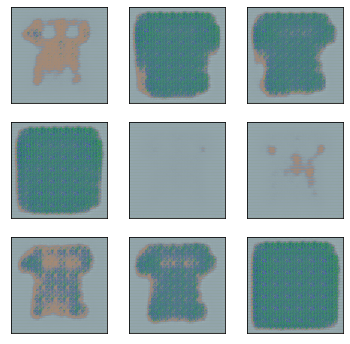

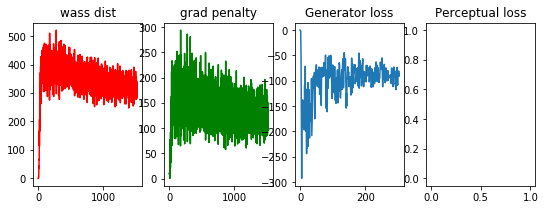

In [16]:
if continue_training:
    last_exp = sorted(os.listdir(exp_path))[-1]
    print ("last_exp", last_exp)
    
    state_dict = torch.load(os.path.join(exp_path, last_exp))
    wd = state_dict['wd']
    gp = state_dict['gp']
    percept_losses = state_dict['percept_losses']
    g_loss = state_dict['g_loss']
    epoch = state_dict['epoch']
    
    print ("start_epoch", epoch)
    
    netG.load_state_dict(state_dict['netG'])
    optimizerG.load_state_dict(state_dict['optimizerG'])
    netD.load_state_dict(state_dict['netD'])
    optimizerD.load_state_dict(state_dict['optimizerD'])
    
    noise = torch.randn(BATCH_SIZE, NOISE_DIM)
    noise = noise.cuda()
    fake = netG(noise)
    vis_batch(fake.detach(), 9)

    fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(9,3))

    axes[0].plot(wd, 'r')
    axes[0].set_title('wass dist')

    axes[1].plot(gp,'g')
    axes[1].set_title('grad penalty')

    axes[2].plot(g_loss)
    axes[2].set_title('Generator loss')
    
    axes[3].plot(percept_losses)
    axes[3].set_title('Perceptual loss')
    
    plt.show()

else:
    start_epoch = 0
    iteration = 0
    wd = []
    gp = []
    g_loss = []
    percept_losses = []

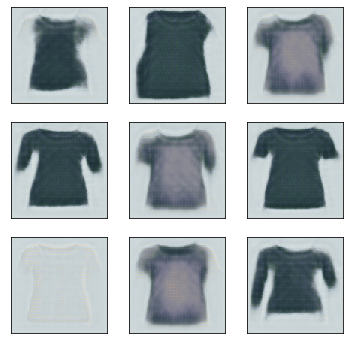

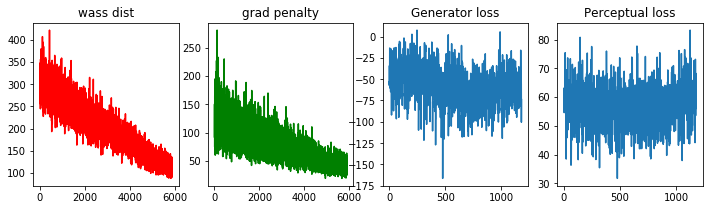

Update D network, epoch 4, iter: 204


In [ ]:
for epoch in range(start_epoch,EPOCHS):
    
    for i,(edges,real_data,mask) in enumerate(train_loader,iteration):
        batch_size = real_data.shape[0]
#         if i >= N:
#             break
        ############################
        # (1) Update D network
        ###########################
        if i%DISCR_FREQ == 0:
            print ('Update D network, epoch {0}, iter: {1}'.format(epoch, i))
            for p in netD.parameters():  
                p.requires_grad = True  

            netD.zero_grad()

            # train with real
            real_data = real_data.cuda()
            D_real = netD(real_data)
            D_real = D_real.mean(0)
            D_real.backward(mone)

            # train with fake
            noise = mn.sample_n(batch_size).view(batch_size, NOISE_DIM)
            noise = noise.cuda()
            fake = netG(noise)
            D_fake = netD(fake)
            D_fake = D_fake.mean(0)
            D_fake.backward(one)

            # train with gradient penalty
            gradient_penalty = calc_gradient_penalty(netD, real_data.data, fake.data)
            gradient_penalty.backward()
            gp.append(gradient_penalty.item())

            # step
            D_cost = D_fake - D_real + gradient_penalty
            Wasserstein_D = D_real - D_fake
            wd.append(Wasserstein_D.item())
            optimizerD.step()
            
        ############################
        # (2) Update G network
        ###########################
        if i%GEN_FREQ == 0:
            print ('Update G network, epoch {0}, iter: {1}'.format(epoch, i))
            for p in netD.parameters():
                p.requires_grad = False 

            netG.zero_grad()
            noise = mn.sample_n(batch_size).view(batch_size, NOISE_DIM)
            noise = noise.cuda()
            fake = netG(noise)
            G = netD(fake)
            G = G.mean(0)
            if use_perceptual_loss:
                perc_loss = PERC_LOSS_WEIGHT * perceptual_loss(real_data.cuda(), fake)
                percept_losses.append(perc_loss.item())
                G = G - perc_loss
            G.backward(mone)    
            G_cost = -G
            optimizerG.step()
            g_loss.append(G_cost.item())
        
        if i%VIS_FREQ==0:
            clear_output(wait=True)
            vis_batch(fake.detach(),9)
            fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12,3))
            
            axes[0].plot(wd, 'r')
            axes[0].set_title('wass dist')
            
            axes[1].plot(gp,'g')
            axes[1].set_title('grad penalty')
            
            axes[2].plot(g_loss)
            axes[2].set_title('Generator loss')
            
            axes[3].plot(percept_losses)
            axes[3].set_title('Perceptual loss')
            plt.show()
    
    if epoch%SAVE_FREQ == 0:
        dict_to_save = {"netD":netD.state_dict(),
                        "netG":netG.state_dict(),
                        "optimizerD":optimizerD.state_dict(),
                        "optimizerG":optimizerG.state_dict(), 
                        "wd":wd,
                        "gp":gp,
                        "g_loss":g_loss,
                        "percept_losses":percept_losses,
                        "epoch":epoch}
        save_dict(exp_path, dict_to_save, 'epoch_{:03}'.format(epoch))
    
       
        